<a href="https://colab.research.google.com/gist/teruyuki-yamasaki/d5f18df141b2334b4629073127344e97/hellobrax01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brax: a differentiable physics engine

[Brax](https://github.com/google/brax) simulates physical systems made up of rigid bodies, joints, and actutators.  Brax provides the function:

$$
\text{qp}_{t+1} = \text{step}(\text{system}, \text{qp}_t, \text{act})
$$

where:
* $\text{system}$ is the static description of the physical system: each body in the world, its weight and size, and so on
* $\text{qp}_t$ is the dynamic state of the system at time $t$: each body's position, rotation, velocity, and angular velocity
* $\text{act}$ is dynamic input to the system in the form of motor actuation

Brax simulations are differentiable: the gradient $\Delta \text{step}$ can be used for efficient trajectory optimization.  But Brax is also well-suited to derivative-free optimization methods such as evolutionary strategy or reinforcement learning.

Let's review how $\text{system}$, $\text{qp}_t$, and $\text{act}$ are used:

In [ ]:
#@title Colab setup and imports

from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np

try:
  import brax
except ImportError:
  from IPython.display import clear_output 
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

## Brax Config

Here's a brax config that defines a bouncy ball:

In [ ]:
#@title A bouncy ball scene
bouncy_ball = brax.Config(dt=0.05, substeps=4) # scene

# ground is a frozen (immovable) infinite plane
ground = bouncy_ball.bodies.add(name='ground')   # add to the scene a body==ground 
ground.frozen.all = True                                         # make the entire body static 
plane = ground.colliders.add().plane                        # add to the body the property of a collider==plane
plane.SetInParent()  # for setting an empty oneof   # regard the plane as a parent 

# ball weighs 1kg, has equal rotational inertia along all axes, is 1m long, and
# has an initial rotation of identity (w=1,x=0,y=0,z=0) quaternion
ball = bouncy_ball.bodies.add(name='ball', mass=1)  # add to the scene a body==ball
cap = ball.colliders.add().capsule                              # add to the body the property of a collider==capsule 
cap.radius, cap.length = 0.5, 1                                 # this radius-length ratio of capsule makes a ball 

# gravity is -9.8 m/s^2 in z dimension
bouncy_ball.gravity.z = -9.8                                    # add to the scene gravity
print(bouncy_ball)

bodies {
  name: "ground"
  colliders {
    plane {
    }
  }
  frozen {
    all: true
  }
}
bodies {
  name: "ball"
  colliders {
    capsule {
      radius: 0.5
      length: 1.0
    }
  }
  mass: 1.0
}
gravity {
  z: -9.800000190734863
}
dt: 0.05000000074505806
substeps: 4



## Brax State

$\text{QP}$,  brax's **dynamic state**, is a structure with the following fields:

In [ ]:
qp_init = brax.QP(
    # position of each body in 3d (z is up, right-hand coordinates)
    pos = np.array([[0., 0., 0.],       # ground
                            [0., 0., 3.]]),     # ball is 3m up in the air
             
    # velocity of each body in 3d
    vel = np.array([[0., 0., 0.],         # ground
                            [0., 0., 0.]]),     # ball
             
    # rotation about center of body, as a quaternion (w, x, y, z)
    rot = np.array([[1., 0., 0., 0.],     # ground
                            [1., 0., 0., 0.]]), # ball
             
    # angular velocity about center of body in 3d
    ang = np.array([[0., 0., 0.],       # ground
                            [0., 0., 0.]])      # ball
)

## Brax Step Function

We visualize this system config like so:

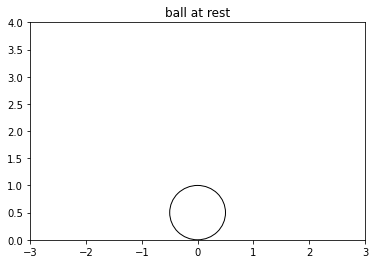

In [ ]:
def draw_system(ax, pos, alpha=1):
    for i, p in enumerate(pos):
        ax.add_patch(Circle(xy=(p[0], p[2]), radius=cap.radius, fill=False, color=(0, 0, 0, alpha)))

    if i < len(pos) - 1: # draw the trajectory 
        pn = pos[i + 1]
        ax.add_line(Line2D([p[0], pn[0]], [p[2], pn[2]], color=(1, 0, 0, alpha)))

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

draw_system(ax, [[0, 0, 0.5]])
plt.title('ball at rest')
plt.show()

Let's observe $\text{step}(\text{config}, \text{qp}_t)$ with a few different variants of $\text{config}$ and $\text{qp}$:

In [ ]:
import copy

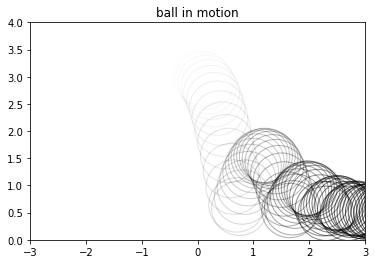

In [ ]:
#@title Simulating the bouncy ball config { run: "auto"}
bouncy_ball.elasticity = 0.8 #@param { type:"slider", min: 0, max: 0.95, step:0.05 }
ball_velocity = 1 #@param { type:"slider", min:-5, max:5, step: 0.5 }

#bouncy_ball.reset() 
bouncy_ball.dynamics_mode  = "legacy_spring"
sys = brax.System(bouncy_ball)

# provide an initial velocity to the ball
qp = copy.deepcopy(qp_init) 
qp.vel[1, 0] = ball_velocity

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

for i in range(100):
  draw_system(ax, qp.pos[1:], i / 100.)
  qp, _ = sys.step(qp, [])

plt.title('ball in motion')
plt.show()

# Joints

Joints constrain the motion of bodies so that they move in tandem:

In [ ]:
#@title A bouncy ball scene
bouncy_ball = brax.Config(dt=0.05, substeps=4)
bouncy_ball.dynamics_mode  = "legacy_spring"

# ground is a frozen (immovable) infinite plane
ground = bouncy_ball.bodies.add(name='ground')
ground.frozen.all = True
plane = ground.colliders.add().plane
plane.SetInParent()  # for setting an empty oneof

# ball weighs 1kg, has equal rotational inertia along all axes, is 1m long, and
# has an initial rotation of identity (w=1,x=0,y=0,z=0) quaternion
ball = bouncy_ball.bodies.add(name='ball', mass=1)
cap = ball.colliders.add().capsule
cap.radius, cap.length = 0.5, 1

# gravity is -9.8 m/s^2 in z dimension
bouncy_ball.gravity.z = -9.8

In [ ]:
#@title A pendulum config for Brax
pendulum = brax.Config(dt=0.01, substeps=4)                     # create a  scene
pendulum.gravity.z = -9.8                                                    # add to the scene gravity==-9.8 m/s^2 in z dimension
pendulum.dynamics_mode  = "legacy_spring"

# start with a frozen anchor at the root of the pendulum
anchor = pendulum.bodies.add(name='anchor', mass=1.0)   # add to the scene a body==anchor
anchor.frozen.all = True                                                      # make the body static 

if 0:
    system = brax.Config(dt=0.01,substeps=4); system.gravity.z=-9.8
    ball = system.bodies.add(name='ball', mass=1)
    cap = ball.colliders.add().capsule
    cap.radius, cap.length = 0.5, 1

# now add a middle and bottom ball to the pendulum
pendulum.bodies.append(ball)                    # add to the scene a body==ball 1
pendulum.bodies.append(ball)                    # add to the scene a body==ball 2
pendulum.bodies[1].name = 'middle'              # name the body 1 as middle 
pendulum.bodies[2].name = 'bottom'              # name the body 2 as bottom 

# connect anchor to middle                          # add to the body a joint==joint 1
joint = pendulum.joints.add(
    name='joint1', 
    parent='anchor',
    child='middle', 
    stiffness=10000, 
    angular_damping=20)
joint.angle_limit.add(min = -180, max = 180)
joint.child_offset.z = 1.5
joint.rotation.z = 90

# connect middle to bottom
pendulum.joints.append(joint)
pendulum.joints[1].name = 'joint2'
pendulum.joints[1].parent = 'middle'
pendulum.joints[1].child = 'bottom'

In [ ]:
print(pendulum)

bodies {
  name: "anchor"
  mass: 1.0
  frozen {
    all: true
  }
}
bodies {
  name: "middle"
  colliders {
    capsule {
      radius: 0.5
      length: 1.0
    }
  }
  mass: 1.0
}
bodies {
  name: "bottom"
  colliders {
    capsule {
      radius: 0.5
      length: 1.0
    }
  }
  mass: 1.0
}
joints {
  name: "joint1"
  stiffness: 10000.0
  parent: "anchor"
  child: "middle"
  child_offset {
    z: 1.5
  }
  rotation {
    z: 90.0
  }
  angular_damping: 20.0
  angle_limit {
    min: -180.0
    max: 180.0
  }
}
joints {
  name: "joint2"
  stiffness: 10000.0
  parent: "middle"
  child: "bottom"
  child_offset {
    z: 1.5
  }
  rotation {
    z: 90.0
  }
  angular_damping: 20.0
  angle_limit {
    min: -180.0
    max: 180.0
  }
}
gravity {
  z: -9.800000190734863
}
dt: 0.009999999776482582
substeps: 4
dynamics_mode: "legacy_spring"



In [ ]:
pendulum.bodies

[name: "anchor"
mass: 1.0
frozen {
  all: true
}
, name: "middle"
colliders {
  capsule {
    radius: 0.5
    length: 1.0
  }
}
mass: 1.0
, name: "bottom"
colliders {
  capsule {
    radius: 0.5
    length: 1.0
  }
}
mass: 1.0
]

In [ ]:
print(pendulum.joints)

[name: "joint1"
stiffness: 10000.0
parent: "anchor"
child: "middle"
child_offset {
  z: 1.5
}
rotation {
  z: 90.0
}
angular_damping: 20.0
angle_limit {
  min: -180.0
  max: 180.0
}
, name: "joint2"
stiffness: 10000.0
parent: "middle"
child: "bottom"
child_offset {
  z: 1.5
}
rotation {
  z: 90.0
}
angular_damping: 20.0
angle_limit {
  min: -180.0
  max: 180.0
}
]


In [ ]:
pendulum.actuators

[]

Here is our system at rest:

QP(pos=array([[0. , 0. , 3.5],
       [0. , 0. , 2. ],
       [0. , 0. , 0.5]]), rot=array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]]), vel=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), ang=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]))


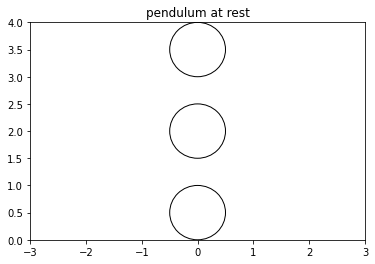

In [ ]:
_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

# rather than building our own qp like last time, we ask brax.System to
# generate a default one for us, which is handy
qp = brax.System(pendulum).default_qp()

print(qp)

draw_system(ax, qp.pos)
plt.title('pendulum at rest')
plt.show()

Let's observe $\text{step}(\text{config}, \text{qp}_t)$ by smacking the bottom ball with an initial impulse, simulating a pendulum swing.

QP(pos=array([[0. , 0. , 3.5],
       [0. , 0. , 2. ],
       [0. , 0. , 0.5]]), rot=array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]]), vel=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), ang=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]))


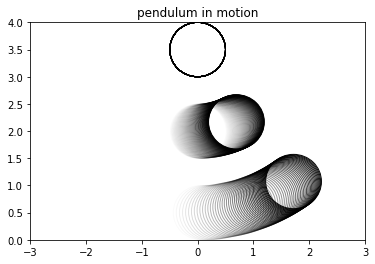

QP(pos=array([[ 0.00000000e+00,  0.00000000e+00,  3.50000000e+00],
       [ 7.02142511e-01, -1.66439330e-16,  2.17253498e+00],
       [ 1.73321594e+00, -4.08940381e-16,  1.08187498e+00]]), rot=array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 9.70572280e-01, -5.61173157e-17, -2.40809987e-01,
        -9.92616777e-19],
       [ 9.29170787e-01, -8.59938454e-17, -3.69650711e-01,
        -1.06105716e-18]]), vel=array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.96546337e-01, 2.01300140e-16, 3.17838897e-01],
       [1.31255895e+00, 4.77685926e-16, 9.97696456e-01]]), ang=array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.12717237e-17, -4.51278730e-01,  1.04488714e-16],
       [ 6.38380888e-17, -6.58458105e-01,  1.60077143e-16]]))


In [ ]:
#@title Simulating the pendulum config { run: "auto"}
ball_impulse = 8 #@param { type:"slider", min:-15, max:15, step: 0.5 }

sys = brax.System(pendulum)
qp = sys.default_qp()

print(qp)

# provide an initial velocity to the ball
qp.vel[2, 0] = ball_impulse

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

for i in range(50):
  draw_system(ax, qp.pos, i / 50.)
  qp, _ = sys.step(qp, [])

plt.title('pendulum in motion')
plt.show()

print(qp)

## Actuators

Actuators provide dynamic input to the system during every physics step.  They provide control parameters for users to manipulate the system interactively via the $\text{act}$ parameter.

In [ ]:
#@title A single actuator on the pendulum
actuated_pendulum = brax.Config()
actuated_pendulum.CopyFrom(pendulum)

# actuating the joint connecting the anchor and middle
angle = actuated_pendulum.actuators.add(name='actuator', joint='joint1',
                                        strength=100).angle
angle.SetInParent()  # for setting an empty oneof

Let's observe $\text{step}(\text{config}, \text{qp}_t, \text{act})$ by raising the middle ball to a desired target angle:

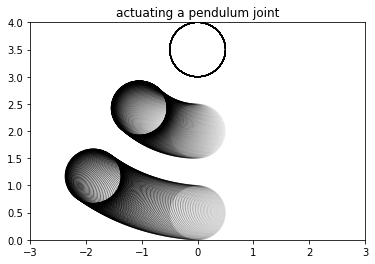

In [ ]:
#@title Simulating the actuated pendulum config { run: "auto"}
target_angle = 45 #@param { type:"slider", min:-90, max:90, step: 1 }

sys = brax.System(actuated_pendulum)
qp = sys.default_qp()
act = np.array([target_angle])

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

for i in range(100):
  draw_system(ax, qp.pos, i / 100.)
  qp, _ = sys.step(qp, act)

plt.title('actuating a pendulum joint')
plt.show()

# Training in Brax

In [ ]:
#@title Import Brax and some helper modules

import functools
import time

from IPython.display import HTML, Image 
import gym

try:
  import brax
except ImportError:
  from IPython.display import clear_output 
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

from brax import envs
from brax import jumpy as jp
from brax.envs import to_torch
from brax.io import html
from brax.io import image
import jax
from jax import numpy as jnp
import torch
v = torch.ones(1, device='cuda')  # init torch cuda before jax

In [Brax Environments](https://colab.research.google.com/github/google/brax/blob/main/notebooks/environments.ipynb#scrollTo=_sOmCoOrF0F8) we learned about creating environments and using them to quickly generate rollouts. We can learn all kinds of fun and useful behaviors on those environments via Brax's built-in training algorithms.

Let's try them out!